#### Cloning the GitHub Repo

In [1]:
!git clone https://github.com/FengheTan9/CMUNeXt.git

Cloning into 'CMUNeXt'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 70 (delta 28), reused 46 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 456.95 KiB | 8.62 MiB/s, done.
Resolving deltas: 100% (28/28), done.


#### Preparing approriate folder structure for our dataset

In [7]:
import os
import shutil

# Define source directories
images_dir = 'data/images'
masks_dir = 'data/masks'

# Define target directory
busi_dir = 'data/busi'

# Create the target directory if it doesn't exist
os.makedirs(busi_dir, exist_ok=True)

# Move images and masks directories into data/busi
if os.path.exists(images_dir):
    shutil.move(images_dir, busi_dir)

if os.path.exists(masks_dir):
    shutil.move(masks_dir, busi_dir)


In [2]:
import os

# Path to the benign folder (adjust if needed)
benign_dir = '/kaggle/working/CMUNeXt/data/images'

# Count PNG images that are NOT masks
num_images_benign = len([
    f for f in os.listdir(benign_dir)
    # if f.endswith('.png') and '_mask' not in f
])

print("Number of images:", num_images_benign)


Number of images: 647


In [4]:
cd /kaggle/working/CMUNeXt

/kaggle/working/CMUNeXt


#### Training

In [8]:
!python split.py --dataset_name busi --dataset_root ./data

build train file successfully, path is: ./data/busi/busi_train.txt
build validate file successfully, path is: ./data/busi/busi_val.txt


In [54]:
!python main.py --model CMUNeXt --base_dir ./data/busi --train_file_dir busi_train.txt --val_file_dir busi_val.txt

total 452  train samples
total 195  val samples
train num:452, val num:195
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train file dir:busi_train.txt val file dir:busi_val.txt
57 iterations per epoch
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number t

#### Testing

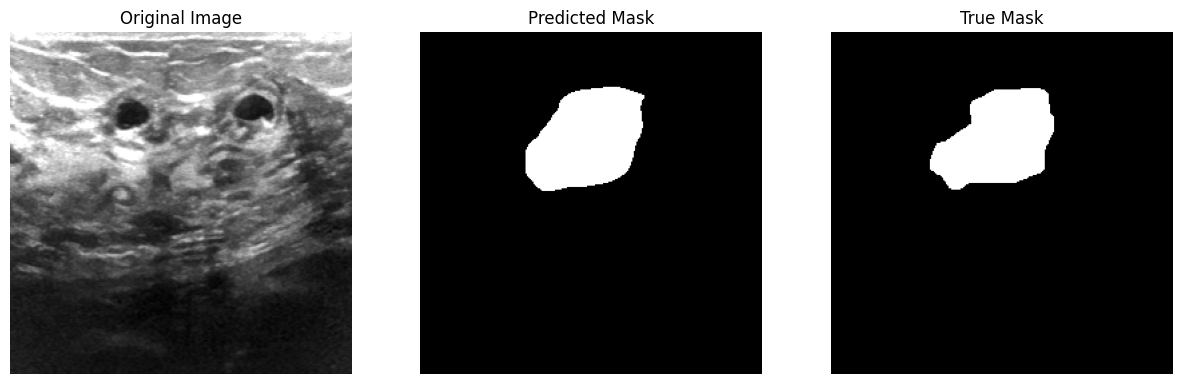

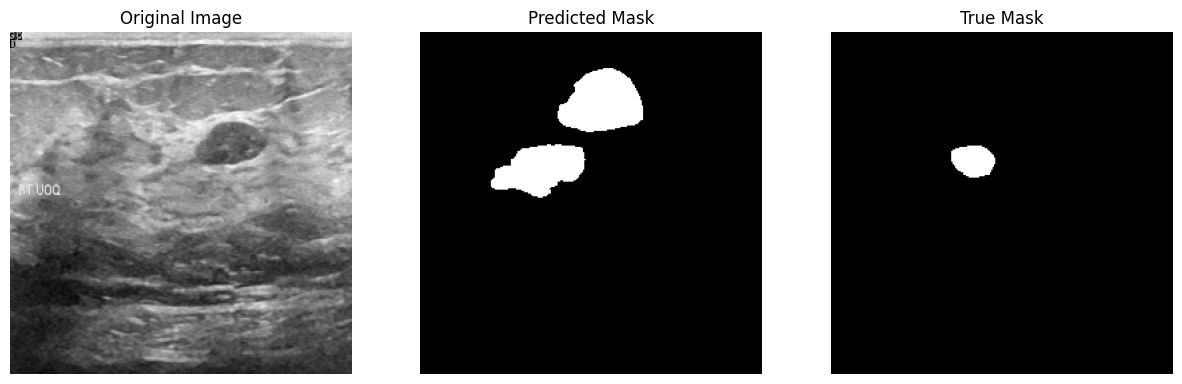

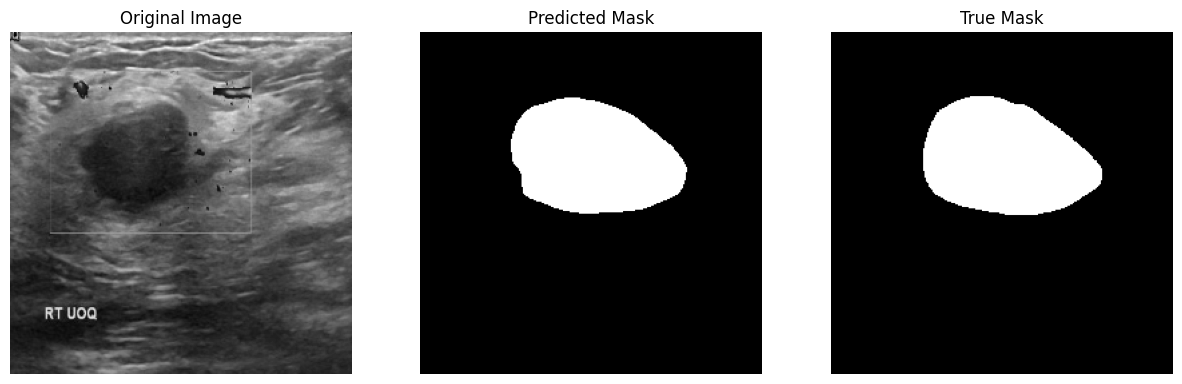

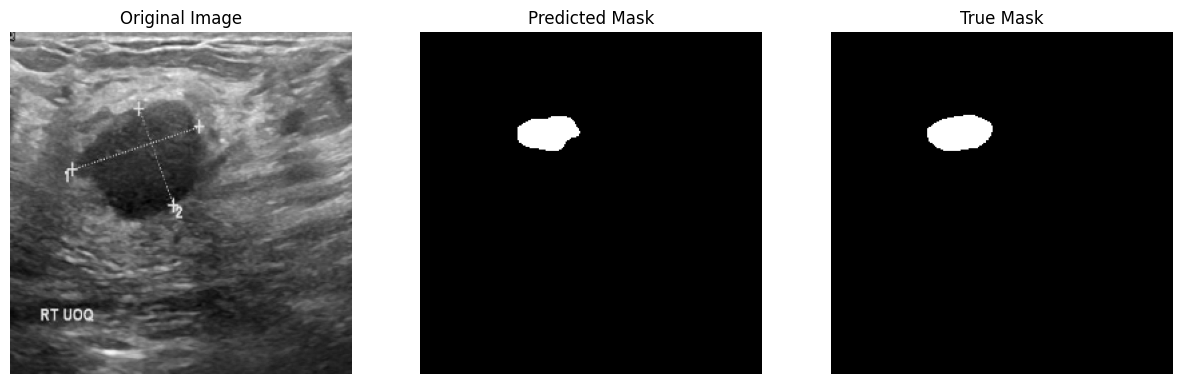

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2
import os

# Create a separate dataset class for display (no normalization)
class DisplayDataset:
    def __init__(self, base_dir, split_file, img_size=256):
        self.base_dir = base_dir
        self.img_size = img_size
        
        # Load sample list
        with open(os.path.join(base_dir, split_file), 'r') as f:
            self.sample_list = [line.strip() for line in f.readlines()]
    
    def get_original_images(self, indices):
        """Get original unprocessed images for display"""
        images = []
        masks = []
        
        for idx in indices:
            case = self.sample_list[idx]
            
            # Load original images without normalization
            img_path = os.path.join(self.base_dir, 'images', f"{case}.png")
            mask_path = os.path.join(self.base_dir, 'masks', '0', f"{case}.png")
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Resize to match model input size
            img = cv2.resize(img, (self.img_size, self.img_size))
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            
            images.append(img)
            masks.append(mask)
            
        return images, masks

# Initialize display dataset
display_dataset = DisplayDataset(data_dir, split_file, img_size)

def plot_predictions(original_img, pred_mask, true_mask):
    plt.figure(figsize=(15, 5))
    
    # Original Image (no normalization - actual ultrasound appearance)
    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')  # Display as grayscale
    plt.title('Original Image')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    # True Mask
    plt.subplot(1, 3, 3)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    
    plt.show()

# Test loop with separate display images
with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader):
        # Get normalized images for model
        processed_images = batch['image'].cuda()
        true_masks = batch['label'].cpu().numpy()
        
        # Get original unnormalized images for display
        batch_indices = list(range(batch_idx * 4, min((batch_idx + 1) * 4, len(dataset))))
        original_images, original_masks = display_dataset.get_original_images(batch_indices)
        
        # Model prediction
        outputs = model(processed_images)
        pred_masks = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(np.uint8)
        
        # Plot results
        for i in range(len(original_images)):
            plot_predictions(
                original_img=original_images[i],  # Unnormalized grayscale image
                pred_mask=pred_masks[i].squeeze(),
                true_mask=true_masks[i].squeeze()
            )
        
        break  # Only show first batch


#### File Handling

In [ ]:
import os
import shutil

# Source directories
src_base = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
benign_dir = os.path.join(src_base, 'benign')
malignant_dir = os.path.join(src_base, 'malignant')

# Target directories
images_target_dir = '/kaggle/working/CMUNeXt/data/images'
masks_target_dir = '/kaggle/working/CMUNeXt/data/masks/0'

# Create target directories if they don't exist
os.makedirs(images_target_dir, exist_ok=True)
os.makedirs(masks_target_dir, exist_ok=True)

def copy_files(src_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith('.png'):
            src_path = os.path.join(src_dir, filename)
            if filename.endswith('_mask.png'):
                # Mask file: strip '_mask' from filename
                new_filename = filename.replace('_mask.png', '.png')
                dst_path = os.path.join(masks_target_dir, new_filename)
            else:
                # Image file
                dst_path = os.path.join(images_target_dir, filename)
            shutil.copy2(src_path, dst_path)

# Copy files from benign and malignant directories
copy_files(benign_dir)
copy_files(malignant_dir)

print("Copying complete!")


In [47]:
import os

# Specify the path to the file you want to delete
file_path = '/kaggle/working/CMUNeXt/main.py'

# Check if the file exists before deleting
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print(f"File not found: {file_path}")


Deleted: /kaggle/working/CMUNeXt/main.py


In [53]:
import shutil
import os

def copy_file_with_replace(src_file, dst_dir):
    # Ensure destination directory exists
    os.makedirs(dst_dir, exist_ok=True)
    # Destination file path
    dst_file = os.path.join(dst_dir, os.path.basename(src_file))
    # Copy file, replacing if it exists
    shutil.copy2(src_file, dst_file)
    print(f"Copied {src_file} to {dst_file} (replaced if existed)")

# Example usage:
copy_file_with_replace('/kaggle/input/bnmml/dataset.py', '/kaggle/working/CMUNeXt/dataloader')


Copied /kaggle/input/bnmml/dataset.py to /kaggle/working/CMUNeXt/dataloader/dataset.py (replaced if existed)
